# Friston 24 Parameter Model

Even after perfect realignment, Friston et. al have shown that movement related artifacts are still extant in the BOLD signal [motion correction paper](https://www.ncbi.nlm.nih.gov/pubmed/8699946). The types of motion artifacts can be divided into two types:

+ motion artifacts due to the per-volume motion: these motion artifacts are due to the motion of the subject's head at the current timepoint.
+ motion artifacts due to preceding volume motion: these artifacts are due to motion of the subject's head at preceding timepoints.

As shown by Friston et al., this motion, while sometimes substantial and making up a significant fraction of the fMRI signal, can be effectively removed by incorporating the subject motion parameters corrected in the volume realignment step into the nuisance GLM to remove motion artifacts. Under this model, the timeseries can be written as follows:

\begin{align}
    Y &= WR + T
\end{align}

where $Y \in \mathbb{R}^{t \times n}$ for $t$ timesteps, $n$ voxels, $W \in \mathbb{R}^{t \times r}$ is our design matrix with $r$ regressors, $R \in \mathbb{R}^{r \times n}$ are our regressor coefficients. Then $WR$ is our contribution to the BOLD signal that is modellable by our identified regressors $W$, and $T \in \mathbb{R}^{t \times n}$ is the true timeseries we seek. 

We can solve this system using the least-squares solution, using the assumption that our term not modellable by our regressors squared should be minimal:

\begin{align}
    W = (R^TR)^{-1}R^TY
\end{align}

We incorporate our nuisance parameters into our design matrix:

\begin{align}
    R = \begin{bmatrix} x_1 & f_{1} & f^2_1 & s_1 & s^2_1 & y_1 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ y_t & f_t & f^2_t & s_t & s^2_t & y_t \end{bmatrix}
\end{align}

where $f$ are our first order regressors estimated by mcflirt, and $s(t) = f(t-1)$ and $s(0) = 0$ are our our regressors dependent on the previous timepoint. Then $f^2(t)$ and $s^2(t)$ are the squared regressors.



# Pseudocode

## Friston Model
Inputs:
+ mc_params $\in \mathbb{R}^{t \times 6}$: a t x 6 array of the x/y/z translational, and x/y/z rotational motion parameters estimated by FLIRT. 

Outputs:
+ friston $\in \mathbb{R}^{t \times 24}$: a t x 24 array of the friston-24 motion regressors.

friston(mc_params):
+ friston = zeros(t, 24)  # initialize the friston regressors
+ friston[:, 0:6] = mc_params  # the 1st order motion parameters
+ friston[:, 6:12] = mc_params.$^2$  # the 2nd order motion parameters
+ friston[1:end, 12:18] = mc_params[0:end - 1, :]  # each timepoint has a regressor of previous timepoint
+ friston[:, 18:24] = friston[:, 12:18].$^2$  # second order regressor of previous timepoint
+ return(friston)

## Implementation

In [2]:
import numpy as np

def friston_model(mc_params):
    (t, m) = mc_params.shape
    friston = np.zeros((t, 4*m))
    # the motion parameters themselves
    friston[:, 0:m] = mc_params
    # square the motion parameters
    friston[:, m:2*m] = np.square(mc_params)

    # use the motion estimated at the preceding timepoint
    # as a regressor
    friston[1:, 2*m:3*m] = mc_params[:-1, :]
    # use the motion estimated at the preceding timepoint
    # squared as a regressor
    friston[:, 3*m:4*m] = np.square(friston[:, 2*m:3*m])
    return friston

# Simulations

## Basic Simulation 

For our first simulation, we will just look at the parameters estimated by the friston model for a simple set of motion regressors. We will use $m=2$ regressors with $100$ timesteps. Our signal will be two linear trends with some normally distributed noise.

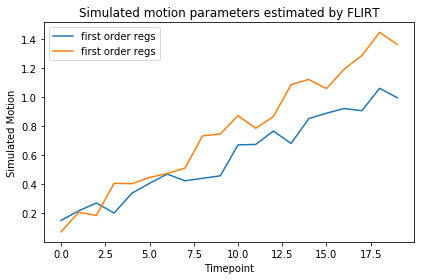

In [54]:
t = 20
m = 2
motion = .2*np.random.rand(t, m) + np.column_stack((.05*np.array(range(0, t)), .07*np.array(range(0, t))))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0, t), motion, label='first order regs')
ax.set_ylabel('Simulated Motion')
ax.set_xlabel('Timepoint')
ax.set_title('Simulated motion parameters estimated by FLIRT')
ax.legend()
fig.tight_layout()
fig.show()

As we can see, we have 2 regressors for motion, which keeps our visualizations as simple as possible (the logic is the same with 6 instead, except we would have 6 lines for each category instead of 2). Below, we visualize the first order motion regressors.

In [48]:
friston = friston_model(motion)

In [49]:
friston.shape == (t, 4*m)  # make sure that we have 4 sets of 2 regressors

True

We will show plots of the first order regressors with the second order regressors, and the shifted regressors, separately to make visualization easier. We know from our friston code the ordering of the regressors so this should be easy:

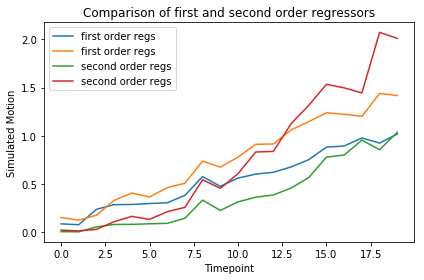

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0, t), motion, label='first order regs')
ax.plot(range(0, t), friston[:, m:2*m], label='second order regs')
ax.set_ylabel('Simulated Motion')
ax.set_xlabel('Timepoint')
ax.set_title('Comparison of first and second order regressors')
ax.legend()
fig.tight_layout()
fig.show()

Visually, these appear to be roughly correct; we can see that the final red timepoint, for instance, is the square of the final orange timepoint. Let's take a look at the other regressors following a similar approach:

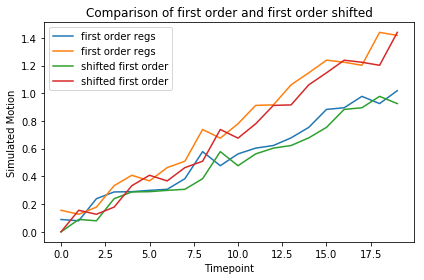

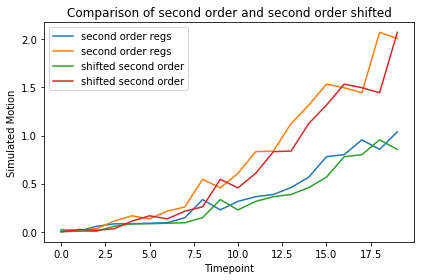

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0, t), motion, label='first order regs')
ax.plot(range(0, t), friston[:, 2*m:3*m], label='shifted first order')
ax.set_ylabel('Simulated Motion')
ax.set_xlabel('Timepoint')
ax.set_title('Comparison of first order and first order shifted')
ax.legend()
fig.tight_layout()
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0, t), friston[:, m:2*m], label='second order regs')
ax.plot(range(0, t), friston[:, 3*m:4*m], label='shifted second order')
ax.set_ylabel('Simulated Motion')
ax.set_xlabel('Timepoint')
ax.set_title('Comparison of second order and second order shifted')
ax.legend()
fig.tight_layout()
fig.show()

As we can see from our shifted regressors, each timepoint's value is the preceding timepoint's estimated motion for both first and second order.